# 02 Standard Metrics

In [1]:
%load_ext autoreload
%autoreload 2
import sys

sys.path.append("../")

import jupyter_black

jupyter_black.load()

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import src.cleansing as cleansing

In [3]:
df = pd.read_csv("../data/Weather Data.csv")

# rename columns
# parse datetime column
df = cleansing.clean_weather_data(df)

## Pearsons' correlation

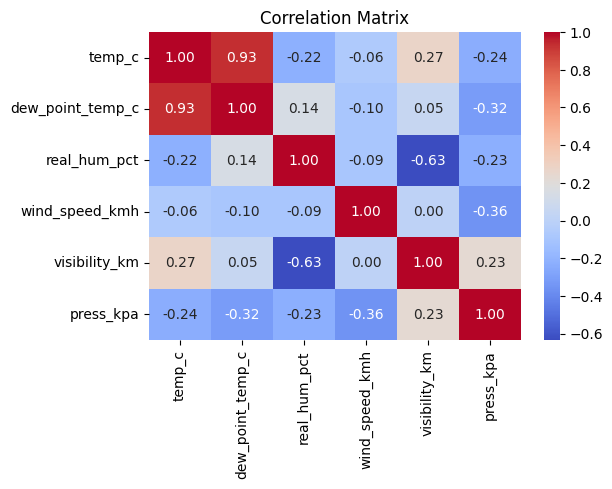

In [55]:
# Pearson correlaation
correlation_matrix = df[df.columns[1:7]].corr()


plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

- 'Real humidity %' and 'Visibility km' have a negative correlation: when theres high humidity, there's low visibility, and vice versa.

- dew point temperature has a positive correlation with temperature 

- dew point temperature has a slight positive correlation with date_time


In [50]:
# save as csv
correlation_matrix.to_csv("../data/results/correlation.csv", index=True)

## Granger Causality

- A small p-value (typically less than the chosen significance level, e.g., 0.05) suggests evidence against the null hypothesis and indicates the presence of Granger causality between the variables.
- A large F-statistic or chi-squared statistic also supports the evidence for Granger causality.
- A large p-value (greater than the significance level) and small values for the statistics imply weak evidence against the null hypothesis, suggesting that there is no Granger causality between the variables.

In [28]:
from src.granger_causality import run_granger_causality_for_dataframe
from src.utils import (
    add_from_and_to_columns,
    get_oscilations,
    get_lag_of_causality_per_pair,
    format_and_convert_to_latex,
)

In [8]:
df_grange = run_granger_causality_for_dataframe(df, max_lag=7 * 24)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=101.8278, p=0.0000  , df_denom=8780, df_num=1
ssr based chi2 test:   chi2=101.8626, p=0.0000  , df=1
likelihood ratio test: chi2=101.2764, p=0.0000  , df=1
parameter F test:         F=101.8278, p=0.0000  , df_denom=8780, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=110.2274, p=0.0000  , df_denom=8777, df_num=2
ssr based chi2 test:   chi2=220.5804, p=0.0000  , df=2
likelihood ratio test: chi2=217.8557, p=0.0000  , df=2
parameter F test:         F=110.2274, p=0.0000  , df_denom=8777, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=118.5252, p=0.0000  , df_denom=8774, df_num=3
ssr based chi2 test:   chi2=355.8592, p=0.0000  , df=3
likelihood ratio test: chi2=348.8375, p=0.0000  , df=3
parameter F test:         F=118.5252, p=0.0000  , df_denom=8774, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=106.2795, p=0.

In [39]:
df_grange

,ColumnX1,ColumnX2,Lag,GrangerCausality,Orientation
0,temp_c,dew_point_temp_c,0,0.000000,from_1_to_2
1,temp_c,dew_point_temp_c,1,0.000000,from_1_to_2
2,temp_c,dew_point_temp_c,2,0.000000,from_1_to_2
3,temp_c,dew_point_temp_c,3,0.000000,from_1_to_2
4,temp_c,dew_point_temp_c,4,0.000000,from_1_to_2
...,...,...,...,...,...
2515,real_hum_pct,wind_speed_kmh,0,0.001098,from_1_to_2
2516,dew_point_temp_c,visibility_km,2,0.003290,from_1_to_2
2517,dew_point_temp_c,visibility_km,1,0.006290,from_1_to_2
2518,dew_point_temp_c,visibility_km,0,0.082605,from_2_to_1


In [40]:
df_grange.sort_values(["GrangerCausality"], ascending=True, inplace=True)
df_grange.head(5)

,ColumnX1,ColumnX2,Lag,GrangerCausality,Orientation
0,temp_c,dew_point_temp_c,0,0.0,from_1_to_2
920,dew_point_temp_c,real_hum_pct,81,0.0,from_2_to_1
919,dew_point_temp_c,real_hum_pct,80,0.0,from_2_to_1
918,dew_point_temp_c,real_hum_pct,79,0.0,from_2_to_1
917,dew_point_temp_c,real_hum_pct,78,0.0,from_2_to_1


/var/folders/sc/92vzjb7j2rg889rjr2c3rd4r0000gn/T/ipykernel_80586/707524706.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_osc_1.sort_index(inplace=True)


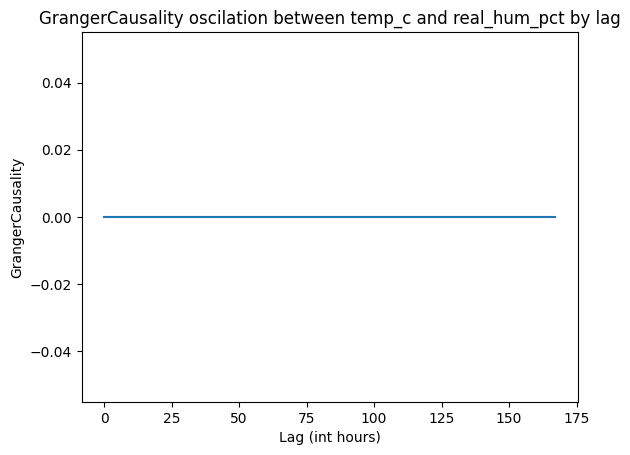

In [41]:
col1 = "temp_c"
col2 = "real_hum_pct"
df_osc_1 = get_oscilations(df_grange, col1, col2)
df_osc_1.set_index("Lag", inplace=True)
df_osc_1.sort_index(inplace=True)
df_osc_1.GrangerCausality.plot()
plt.title(f"GrangerCausality oscilation between {col1} and {col2} by lag")
plt.xlabel("Lag (int hours)")
plt.ylabel("GrangerCausality")
plt.show()

In [42]:
df_granger_for_weather = get_lag_of_causality_per_pair(
    df_grange, causality_column="GrangerCausality", is_max=False
)

In [43]:
df_granger_for_weather

,ColumnX1,ColumnX2,Lag,GrangerCausality,Orientation
232,dew_point_temp_c,press_kpa,33,0.000000e+00,from_1_to_2
1,dew_point_temp_c,real_hum_pct,81,0.000000e+00,from_2_to_1
387,dew_point_temp_c,visibility_km,64,0.000000e+00,from_2_to_1
104,dew_point_temp_c,wind_speed_kmh,0,0.000000e+00,from_1_to_2
22,real_hum_pct,press_kpa,36,0.000000e+00,from_1_to_2
87,real_hum_pct,visibility_km,138,0.000000e+00,from_1_to_2
342,real_hum_pct,wind_speed_kmh,30,0.000000e+00,from_2_to_1
0,temp_c,dew_point_temp_c,0,0.000000e+00,from_1_to_2
115,temp_c,press_kpa,15,0.000000e+00,from_1_to_2
689,temp_c,real_hum_pct,64,0.000000e+00,from_1_to_2


In [44]:
df_granger_for_weather_summary = add_from_and_to_columns(df_granger_for_weather)

In [45]:
df_granger_for_weather_summary.drop(["ColumnX1", "ColumnX2", "Orientation"], axis=1, inplace=True)

In [46]:
df_granger_for_weather_summary

,Lag,GrangerCausality,from_column,to_column
232,33,0.000000e+00,dew_point_temp_c,press_kpa
1,81,0.000000e+00,real_hum_pct,dew_point_temp_c
387,64,0.000000e+00,visibility_km,dew_point_temp_c
104,0,0.000000e+00,dew_point_temp_c,wind_speed_kmh
22,36,0.000000e+00,real_hum_pct,press_kpa
87,138,0.000000e+00,real_hum_pct,visibility_km
342,30,0.000000e+00,wind_speed_kmh,real_hum_pct
0,0,0.000000e+00,temp_c,dew_point_temp_c
115,15,0.000000e+00,temp_c,press_kpa
689,64,0.000000e+00,temp_c,real_hum_pct


In [47]:
# save as csv
df_granger_for_weather_summary.to_csv("../data/results/granger_causality_p_values.csv", index=False)

## Convert to LaTex

In [30]:
latex_table = format_and_convert_to_latex(
    df_granger_for_weather_summary, causality_col="GrangerCausality"
)
print(latex_table)

\begin{tabular}{llrr}
\toprule
From Column & To Column & Lag (days) & GrangerCausality \\
\midrule
Dew P. Temp C & Press kPa & 1.42 & 0.00 \\
Rel Hum \% & Dew P. Temp C & 0.75 & 0.00 \\
Visibility km & Dew P. Temp C & 0.79 & 0.00 \\
Dew P. Temp C & WindSpeed km/h & 0.00 & 0.00 \\
Rel Hum \% & Press kPa & 3.62 & 0.00 \\
Rel Hum \% & Visibility km & 4.92 & 0.00 \\
WindSpeed km/h & Rel Hum \% & 1.25 & 0.00 \\
Temp C & Dew P. Temp C & 0.00 & 0.00 \\
Temp C & Press kPa & 0.58 & 0.00 \\
Temp C & Rel Hum \% & 0.04 & 0.00 \\
Temp C & Visibility km & 0.29 & 0.00 \\
WindSpeed km/h & Temp C & 0.04 & 0.00 \\
Visibility km & Press kPa & 6.88 & 0.00 \\
WindSpeed km/h & Press kPa & 2.12 & 0.00 \\
Visibility km & WindSpeed km/h & 0.42 & 0.00 \\
\bottomrule
\end{tabular}



## Presenting the causality


In [31]:
from src.visualisations import plot_dag

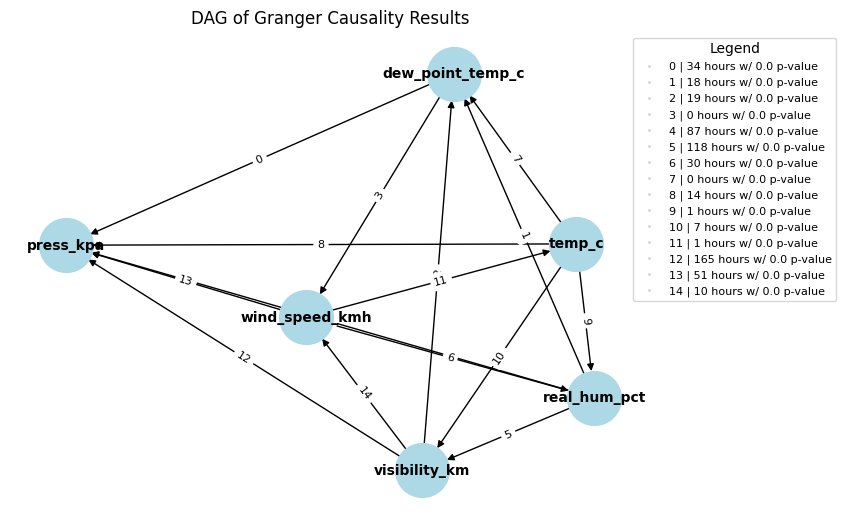

In [35]:
plot_dag(
    df_granger_for_weather_summary,
    causality_title="Granger Causality",
    causality_column="GrangerCausality",
    do_convert_the_column_names=True,
)